# Customer Segmentation using RFM Model

The purpose of this project is to share some experiences I had with customer segmentation using a RFM model. Also I learned a lot from the course "Customer Segmentation in Python" in DataCamp. I tried to apply what I learned into this project as well.

RFM is one of the most widely used techniques for selecting significant customers. It is a very popular customer segmentation technique that uses the customers’ past purchase behavior to divide them into different groups based on similarities.
The name RFM stands for Recency, Frequency, and Monetary value.
* Recency - days since last customer transaction 
* Frequency - number of transactions in the last 12 months
* Monetary Value - total spend in the last 12 months

#### Context: 
Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

#### Data: https://www.kaggle.com/carrie1/ecommerce-data
* This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."
* This dataframe contains 8 variables that correspond to:
    1. InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
    2. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
    3. Description: Product (item) name. Nominal.
    4. Quantity: The quantities of each product (item) per transaction. Numeric.
    5. InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
    6. UnitPrice: Unit price. Numeric, Product price per unit in sterling.
    7. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
    8. Country: Country name. Nominal, the name of the country where each customer resides.
* For easy analysis, I defined the data scope:
    1. Country: United Kingdom 
    2. Timeframe: 1 year (from 2010-12-10 to 2011-12-09)
    3. CustomerID is not null
    4. Do not consider returning: Quantity > 0

# 1. Imports

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

#import plotly
#import plotly.graph_objs as go
#Jupyter setup
#init_notebook_mode(connected=True)
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


warnings.filterwarnings("ignore")

# Reading Data

In [28]:
#load the dataset
data = pd.read_csv('/Users/lirong/Documents/Gloria/Training/Project/E_CommerceData.csv',
                   encoding="ISO-8859-1",
                   dtype={'CustomerID': str},
                   parse_dates=['InvoiceDate'], 
                   index_col='InvoiceDate')
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom


# EDA

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   406829 non-null  object 
 6   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [30]:
print('Dataframe shape:', data.shape)

Dataframe shape: (541909, 7)


In [31]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Weird: min of UnitPrice is zero; min of Quantity is -80995. Need to check again later.

### Check NA

There are some NA in both CustomerID and Descriptio.

In [32]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [33]:
#remove rows where customerID are NA
df = data.dropna(axis = 0, 
                 subset = ['CustomerID'])
print('Dataframe shape:', df.shape)

Dataframe shape: (406829, 7)


In [34]:
# check if any NA
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Check duplicates

In [35]:
# Check if any duplicates
df.duplicated().sum()

5226

In [36]:
# Remove duplicates
df = df.drop_duplicates()
df.shape

(401603, 7)

### Remove cancelled orders
First of all, I count the number of transactions corresponding to canceled orders:

In [37]:
df['order_canceled'] = df['InvoiceNo'].apply(
                                            lambda x: int('C' in x))
df.order_canceled.value_counts()/df.shape[0]

0    0.977909
1    0.022091
Name: order_canceled, dtype: float64

In [38]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,order_canceled
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,0
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,0
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,0
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,0
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,0


In [39]:
# reomve canceled orders
df = df[df.order_canceled == 0]
df= df.drop('order_canceled', axis=1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom


### Only keep orders from United Kingdom

In [40]:
df.Country.value_counts()

United Kingdom          349226
Germany                   9027
France                    8327
EIRE                      7228
Spain                     2480
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1453
Australia                 1184
Norway                    1072
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

In [41]:
df = df[df.Country =='United Kingdom']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom


In [42]:
df.describe()

,Quantity,UnitPrice
count,349226.000000,349226.000000
mean,12.181324,2.972127
std,191.797744,17.990333
min,1.000000,0.000000
25%,2.000000,1.250000
50%,4.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [48]:
df = df[df.UnitPrice>0]
df.shape

(349202, 7)

In [49]:
df.describe()

,Quantity,UnitPrice
count,349202.000000,349202.000000
mean,12.145701,2.972331
std,190.629090,17.990934
min,1.000000,0.001000
25%,2.000000,1.250000
50%,4.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [50]:
#create column total cost
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

In [51]:
df.describe()

,Quantity,UnitPrice,TotalSpend
count,349202.000000,349202.000000,349202.000000
mean,12.145701,2.972331,20.861910
std,190.629090,17.990934,328.417744
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.200000
50%,4.000000,1.950000,10.200000
75%,12.000000,3.750000,17.850000
max,80995.000000,8142.750000,168469.600000


In [52]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
TotalSpend     0
dtype: int64

In [54]:
# drop Country columns because only UK
df = df.drop('Country', axis=1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,TotalSpend
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,20.34


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 349202 entries, 2010-12-01 08:26:00 to 2011-12-09 12:49:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    349202 non-null  object 
 1   StockCode    349202 non-null  object 
 2   Description  349202 non-null  object 
 3   Quantity     349202 non-null  int64  
 4   UnitPrice    349202 non-null  float64
 5   CustomerID   349202 non-null  object 
 6   TotalSpend   349202 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 21.3+ MB


### Check time period

In [56]:
#get Year & Month
df['Date'] = df.index.date
df['Year'] = df.index.year # add Year column
df['Month'] = df.index.month# add Month column
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,TotalSpend,Date,Year,Month
InvoiceDate,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,15.30,2010-12-01,2010,12
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,20.34,2010-12-01,2010,12
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,22.00,2010-12-01,2010,12
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,20.34,2010-12-01,2010,12
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,20.34,2010-12-01,2010,12


In [57]:
pd.crosstab(df.Year, df.Month, margins = True, margins_name = 'Grand Total')

Month,1,2,3,4,5,6,7,8,9,10,11,12,Grand Total
Year,,,,,,,,,,,,,
2010,0,0,0,0,0,0,0,0,0,0,0,23458,23458
2011,17918,17538,23709,20656,24958,23458,23359,22894,35278,42993,57460,15523,325744
Grand Total,17918,17538,23709,20656,24958,23458,23359,22894,35278,42993,57460,38981,349202


In [58]:
print('Min:{}; Max:{}'.format(min(df.Date),
                             max(df.Date)))

Min:2010-12-01; Max:2011-12-09


Need to restrict the data to one full year 

In [60]:
#restrict the data to one full year 
df = df[df.Date > (max(df.Date) - dt.timedelta(days=365))]

In [61]:
# double check if data with only the latest 12 months of data
print('Min:{}; Max:{}'.format(min(df.Date),
                             max(df.Date)))

Min:2010-12-10; Max:2011-12-09


In [62]:
print('Tranctions #:',df['InvoiceNo'].nunique())
print('Product #:',df['StockCode'].nunique())
print('CustomerID #:',df['CustomerID'].nunique())
#print('Country #:',df['Country'].nunique())

Tranctions #: 15929
Product #: 3609
CustomerID #: 3854


In [330]:
t = df.StockCode.value_counts()/df.shape[0]
t.head(20)

85123A    0.005282
85099B    0.004198
22423     0.003941
47566     0.003899
84879     0.003762
20725     0.003326
20727     0.003036
23203     0.003024
22720     0.002969
22383     0.002897
23298     0.002812
23209     0.002791
22197     0.002727
22457     0.002703
20728     0.002645
22382     0.002582
22469     0.002567
21034     0.002555
22384     0.002552
22086     0.002552
Name: StockCode, dtype: float64

# RFM Analysis

## Define snapshot day

In [63]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,TotalSpend,Date,Year,Month
InvoiceDate,,,,,,,,,,
2010-12-10 09:33:00,538172,21562,HAWAIIAN GRASS SKIRT,12,1.25,15805,15.0,2010-12-10,2010,12
2010-12-10 09:33:00,538172,79321,CHILLI LIGHTS,8,4.95,15805,39.6,2010-12-10,2010,12
2010-12-10 09:33:00,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2.55,15805,30.6,2010-12-10,2010,12
2010-12-10 09:33:00,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2.95,15805,35.4,2010-12-10,2010,12
2010-12-10 09:33:00,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,0.55,15805,13.2,2010-12-10,2010,12


In [64]:
#Let's create a hypothetical snapshot_day data as if we're doing analysis recently.

snapshot_date = max(df.Date) + dt.timedelta(days=1)
snapshot_date

datetime.date(2011, 12, 10)

## RFM Table

In [65]:
# Aggregate data on a customer level
rfm = df.groupby(['CustomerID']).agg({
    'Date': lambda x: (snapshot_date - x.max()).days, #Recency
    'InvoiceNo': 'nunique', #Frequency
    'TotalSpend': 'sum'}) #MonetaryValue

# Rename columns for easier interpretation
rfm.rename(columns = {'Date': 'Recency',
                      'InvoiceNo': 'Frequency',
                      'TotalSpend': 'Monetary'}, inplace=True)

# Check the first rowsdatamart.head()
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12747,3,10,3837.45
12748,1,192,31081.74
12749,4,5,4090.88
12820,4,4,942.34


helps us to know how many times a customer purchased from us. To do that we need to check how many invoices are registered by the same customer.

In [66]:
rfm.describe()

,Recency,Frequency,Monetary
count,3854.000000,3854.000000,3854.000000
mean,87.980540,4.133108,1818.263255
std,93.431824,6.889637,7190.913968
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,291.910000
50%,50.000000,2.000000,638.540000
75%,134.000000,4.750000,1545.567500
max,365.000000,192.000000,231822.690000


In [67]:
# Create labels for Recency
r_labels = range(4, 0, -1)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
# Create new columns R and F 
myrfm = rfm.assign(R = r_groups.values)

# frequency quartile segmentation
f_labels = range(1, 5)
frequency = rfm['Frequency'].rank(method='first') # rank to deal with duplicate values
f_quartiles, bins = pd.qcut(frequency, 4, labels=f_labels, retbins=True)
myrfm = myrfm.assign(F = f_quartiles.values)


# Monetary segmentation
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)
# Create new column M
myrfm = myrfm.assign(M = m_groups.values)

myrfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346,326,1,77183.60,1,1,4
12747,3,10,3837.45,4,4,4
12748,1,192,31081.74,4,4,4
12749,4,5,4090.88,4,4,4
12820,4,4,942.34,4,3,3


## Build RFM segment and RFM score

In [68]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

myrfm['RFM_Segment'] = myrfm.apply(join_rfm, axis=1)
myrfm['RFM_Score'] = myrfm[['R','F','M']].sum(axis=1)
myrfm.head(20)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,4,114,6.0
12747,3,10,3837.45,4,4,4,444,12.0
12748,1,192,31081.74,4,4,4,444,12.0
12749,4,5,4090.88,4,4,4,444,12.0
12820,4,4,942.34,4,3,3,433,10.0
12821,215,1,92.72,1,1,1,111,3.0
12822,71,2,948.88,2,2,3,223,7.0
12823,75,5,1759.50,2,4,4,244,10.0
12824,60,1,397.12,2,1,2,212,5.0


In [69]:
myrfm.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    446
111    268
344    189
112    159
121    159
333    156
233    136
211    125
433    124
122    111
dtype: int64

In [70]:
#Select bottom RFM segment"111" and view top5 rows 
myrfm[myrfm['RFM_Segment']=='111'][:5]

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12821,215,1,92.72,1,1,1,111,3.0
12831,263,1,215.05,1,1,1,111,3.0
12837,174,1,134.10,1,1,1,111,3.0
12864,139,1,147.12,1,1,1,111,3.0
12872,327,1,221.44,1,1,1,111,3.0


In [71]:
#Summary metrics per RFM score
myrfm.groupby('RFM_Score').agg({'Recency': 'mean',
                                'Frequency': 'mean',
                                'Monetary': ['mean', 'count'] }).round(1)


Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         250.3       1.0    159.0   268
4.0         196.4       1.1    249.0   443
5.0         126.0       1.3    345.7   447
6.0          88.4       1.6    630.7   451
7.0          77.0       2.1    650.6   375
8.0          58.7       2.8   1083.0   367
9.0          41.8       3.5   1267.0   380
10.0         34.9       5.1   2295.2   344
11.0         21.5       7.5   3111.0   333
12.0          7.7      14.6   7773.9   446

## Segmentation

In [72]:
def my_segment(df):
    if df['RFM_Score'] >= 11:
        return'1.VIP'
    elif (df['RFM_Score'] >= 9) and (df['RFM_Score'] < 11):
        return'2.Gold Customer'
    elif (df['RFM_Score'] >= 6) and (df['RFM_Score'] < 9):
        return'3.Silver Customer'
    elif (df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6):
        return'4.Potential Customer'
    else:
        return'5.Require Activation'

myrfm['General_Segment'] = myrfm.apply(my_segment, 
                                       axis=1)

myrfm.groupby('General_Segment').agg({'Recency': 'mean',
                                      'Frequency': 'mean',
                                      'Monetary': ['mean', 'count']}).round(1)


Recency Frequency Monetary      
                        mean      mean     mean count
General_Segment                                      
1.VIP                   13.6      11.5   5780.7   779
2.Gold Customer         38.5       4.2   1755.6   724
3.Silver Customer       75.6       2.1    776.1  1193
4.Potential Customer   161.0       1.2    297.6   890
5.Require Activation   250.3       1.0    159.0   268

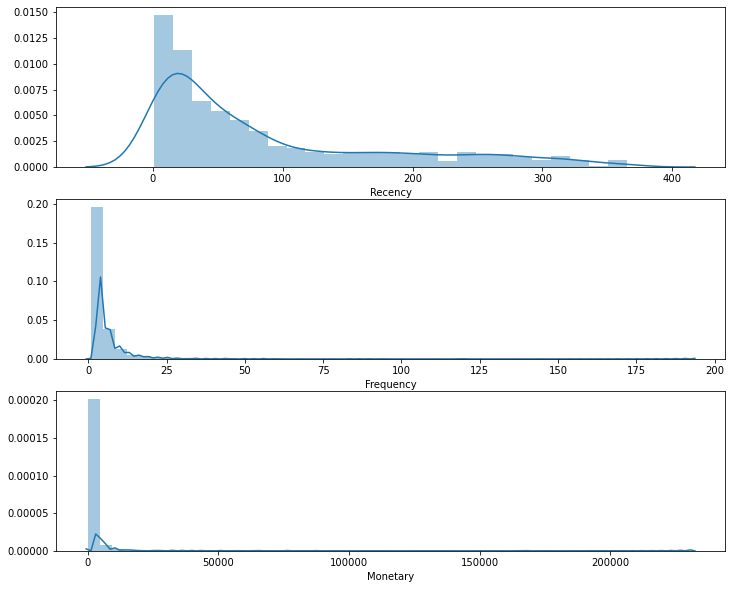

In [73]:
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(myrfm['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(myrfm['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(myrfm['Monetary'])
# Show the plot
plt.show()